Running simulation for 20 nodes to poll...
Completed simulation for 20 nodes to poll.
Nodes to poll: 20
  Average MSE: 0.04597086423419771
  Average sensor lifetime (years): 3.1896676714915597


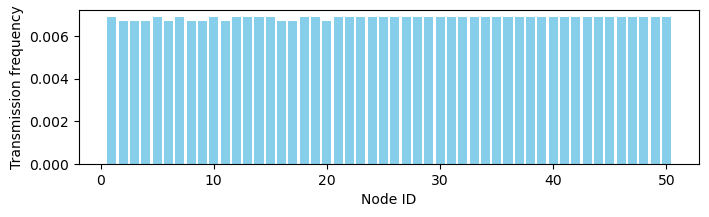

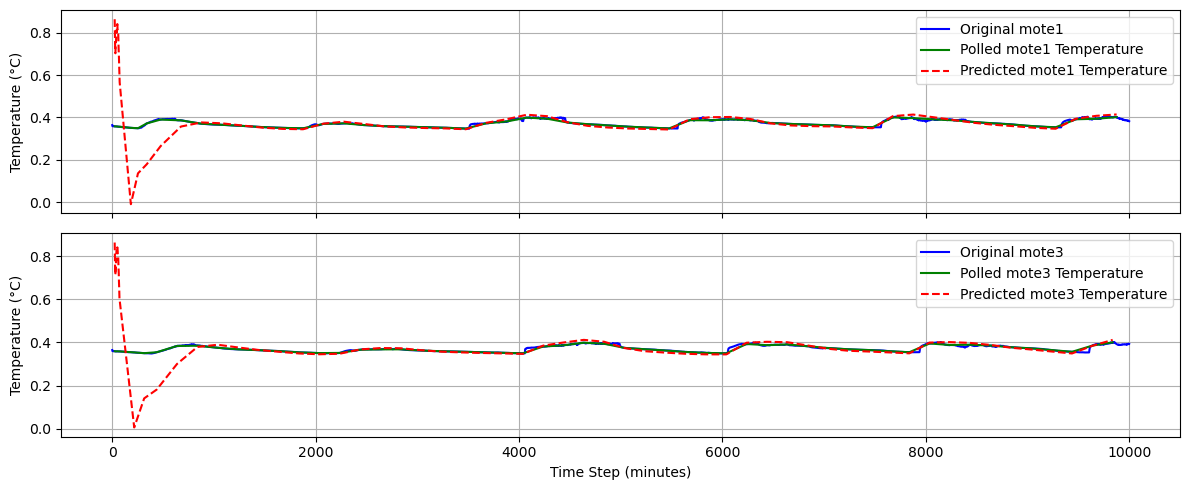

: 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the pivot DataFrame
pivot_df = pd.read_csv('top_fifty_motes_temperatures.csv')
pivot_df = pivot_df.head(10000)

# Pre-determined min and max values for normalization (example values)
temperature_min, temperature_max = -40, 125  # in degrees Celsius

# Normalize function
def normalize(value, min_val, max_val):
    return (value - min_val) / (max_val - min_val)

# Normalize temperature data in the DataFrame
for mote in pivot_df.columns[1:]:  # Assuming the first column is an index or non-mote column
    pivot_df[mote] = pivot_df[mote].apply(normalize, args=(temperature_min, temperature_max))

# Parameters
H = np.array([[1, 0]])                # Measurement matrix
Q = np.array([[1e-5, 0], [0, 1e-5]])  # Process noise covariance
R = np.array([[0.5]])                 # Measurement noise covariance

# Normalized thresholds
epsilon = normalize(0.3, temperature_min, temperature_max)  # Sensitivity threshold for event detection
theta = normalize(0.3, temperature_min, temperature_max)    # Threshold for significant change

num_nodes_to_poll_list = [20]         # List of numbers of nodes to poll
force_pull_threshold = 200            # Forcefully pull a node if it hasn't been pulled in the last 10 time steps

# Energy parameters in Joules
E_max = 162000  # Battery capacity in Joules
E_t = 50 / 1000  # Transmission energy in Joules
E_s = 10 / 1000  # Sensing energy in Joules
E_w = 10 / 1000  # Wake-up energy in Joules
E_0 = 1 / 1000   # Sleep energy in Joules

# UCB parameters
alpha = 2  # Exploration parameter for UCB

# BanditArm class
class BanditArm:
    def __init__(self, initial_value=0.):
        self.value_estimate = initial_value
        self.N = 0  # Number of samples collected so far

    def update(self, value):
        self.N += 1
        self.value_estimate = ((self.N - 1) * self.value_estimate + value) / self.N

def ucb(p_estimate, total_pulls, n):
    return p_estimate + np.sqrt(2 * np.log(total_pulls) / n) if n > 0 else float('inf')

def get_state_transition_matrix(delta_t):
    return np.array([[1, delta_t], [0, 1]])

def run_simulation(num_nodes_to_poll):
    # Normalize the initial temperature estimate
    initial_temp_estimate = normalize(20, temperature_min, temperature_max)

    state_estimates = {f'mote{i}': np.array([[initial_temp_estimate], [0.01]]) for i in range(1, 51)}
    P = {f'mote{i}': np.zeros((2, 2)) for i in range(1, 51)}  # Initialize to zeros
    
    last_sensed_values = {f'mote{i}': initial_temp_estimate for i in range(1, 51)}
    last_update_times = {f'mote{i}': 0 for i in range(1, 51)}
    
    valuable_sensor_data = []
    polled_count = {f'mote{i}': 0 for i in range(1, 51)}
    transmitted_count = {f'mote{i}': 0 for i in range(1, 51)}
    bandit_arms = {f'mote{i}': BanditArm() for i in range(1, 51)}
    
    previously_polled_nodes = set()  # Initialize previously_polled_nodes

    def predict_node_state(x_hat, delta_t):
        A_delta = get_state_transition_matrix(delta_t)  # Adjust the state transition matrix for the time step
        return A_delta @ x_hat

    def select_nodes_to_poll(state_estimates, P, last_update_times, last_sensed_values, current_time_step, num_nodes_to_poll, previously_polled_nodes):
        total_pulls = sum(polled_count.values())
        ucb_values = {
            mote: ucb(bandit_arms[mote].value_estimate, total_pulls, polled_count[mote])
            for mote in state_estimates
        }
        # Select top M nodes based on UCB scores
        nodes_by_ucb = sorted(ucb_values.keys(), key=lambda mote: ucb_values[mote], reverse=True)
        top_m_nodes = nodes_by_ucb[:num_nodes_to_poll]

        # Filter the top M nodes based on the prediction threshold
        nodes_to_poll = []
        for mote in top_m_nodes:
            delta_t = current_time_step - last_update_times[mote]
            if delta_t > 0:
                predicted_state = predict_node_state(state_estimates[mote], delta_t)
                predicted_value = H @ predicted_state
                current_value = last_sensed_values[mote]
                if abs(predicted_value - current_value) > theta and mote not in previously_polled_nodes:
                    nodes_to_poll.append(mote)
        
        return nodes_to_poll

    for idx, row in pivot_df.iterrows():
        current_time_step = idx
        currently_polled_nodes = set()

        for mote, last_time in last_update_times.items():
            if current_time_step - last_time >= force_pull_threshold:
                currently_polled_nodes.add(mote)

        nodes_to_poll = select_nodes_to_poll(state_estimates, P, last_update_times, last_sensed_values, current_time_step, num_nodes_to_poll, previously_polled_nodes)
        nodes_to_poll = list(currently_polled_nodes) + nodes_to_poll

        for mote in nodes_to_poll:
            polled_count[mote] += 1
            transmitted_count[mote] += 1
            measured_value = row[mote]
            previous_state = state_estimates[mote]
            previous_P = P[mote]
            delta_t = max(current_time_step - last_update_times[mote], 1)
            A_delta = get_state_transition_matrix(delta_t)  # Get the dynamic state transition matrix

            xp = A_delta @ previous_state
            Pp = A_delta @ previous_P @ A_delta.T + Q

            z = np.array([[measured_value]])
            K = Pp @ H.T @ np.linalg.inv(H @ Pp @ H.T + R)
            x_hat = xp + K @ (z - H @ xp)
            P_hat = Pp - K @ H @ Pp

            state_estimates[mote] = x_hat
            P[mote] = P_hat

            predicted_measurement = predict_node_state(previous_state, delta_t)[0, 0]
            diff = abs(predicted_measurement - measured_value)
            bandit_arms[mote].update(diff)

            predicted_measurement = predict_node_state(state_estimates[mote], delta_t)[0, 0]
            diff = abs(predicted_measurement - measured_value)

            valuable_sensor_data.append({
                'index': current_time_step,
                'selected_moteid': mote,
                'Temperature': measured_value,
                'predicted temperature': predicted_measurement,
                'time_elapsed': delta_t
            })

        previously_polled_nodes = set(nodes_to_poll)

        for mote in nodes_to_poll:
            last_update_times[mote] = current_time_step
            last_sensed_values[mote] = row[mote]

    valuable_sensor_df = pd.DataFrame(valuable_sensor_data)

    valuable_sensor_df['squared_error'] = (valuable_sensor_df['Temperature'] - valuable_sensor_df['predicted temperature']) ** 2
    average_mse = valuable_sensor_df['squared_error'].mean()

    time_steps = len(pivot_df)
    fw = {mote: polled_count[mote] / time_steps for mote in polled_count}
    ft = {mote: transmitted_count[mote] / time_steps for mote in transmitted_count}

    average_lifetime_hours = np.mean([
        E_max / (ft[mote] * E_t + fw[mote] * (E_s + 3 * E_w) + (1 - fw[mote]) * E_0) for mote in polled_count
    ]) / 3600

    average_lifetime_years = average_lifetime_hours / 8760

    return average_mse, average_lifetime_years, transmitted_count, valuable_sensor_df

results = {}
valuable_sensor_df_list = []

for num_nodes_to_poll in num_nodes_to_poll_list:
    print(f"Running simulation for {num_nodes_to_poll} nodes to poll...")
    mse, lifetime, transmitted_count, valuable_sensor_df = run_simulation(num_nodes_to_poll)
    results[num_nodes_to_poll] = {'MSE': mse, 'Lifetime (years)': lifetime}
    valuable_sensor_df_list.append((num_nodes_to_poll, valuable_sensor_df))
    print(f"Completed simulation for {num_nodes_to_poll} nodes to poll.")

# Print the results
for num_nodes_to_poll, metrics in results.items():
    print(f"Nodes to poll: {num_nodes_to_poll}")
    print(f"  Average MSE: {metrics['MSE']}")
    print(f"  Average sensor lifetime (years): {metrics['Lifetime (years)']}")

# Plot the total transmission count for each node against the total simulation time steps
total_duration = len(pivot_df)
ratios = {int(mote.replace('mote', '')): transmitted_count[mote] / total_duration for mote in transmitted_count}

plt.figure(figsize=(8, 2))
plt.bar(ratios.keys(), ratios.values(), color='skyblue')
plt.xlabel('Node ID')
plt.ylabel('Transmission frequency')

# Set x-ticks at intervals of 10
ticks = list(range(0, 51, 10))
plt.xticks(ticks)

plt.show()

# Plot valuable_sensor_df data for the first simulation
fig, axs = plt.subplots(2, 1, figsize=(12, 5), sharex=True)

num_nodes_to_poll, valuable_sensor_df = valuable_sensor_df_list[0]

for i, mote in enumerate(['mote1', 'mote3']):
    # Plot original data from the node end
    axs[i].plot(pivot_df['SN'], pivot_df[mote], 'b-', label=f'Original {mote}')
    
    # Plot data collected from the sink end
    mote_data = valuable_sensor_df[valuable_sensor_df['selected_moteid'] == mote]
    axs[i].plot(mote_data['index'], mote_data['Temperature'], 'g-', label=f'Polled {mote} Temperature')
    axs[i].plot(mote_data['index'], mote_data['predicted temperature'], 'r--', label=f'Predicted {mote} Temperature')
    
    axs[i].set_ylabel('Temperature (°C)')
    axs[i].legend()
    axs[i].grid(True)

axs[-1].set_xlabel('Time Step (minutes)')
plt.tight_layout()
plt.show()
